# Digit Recognizer: sklearn load_digits Dataset

이 데이터셋은 0부터 9까지의 손글씨 숫자(Handwritten Digits) 이미지 데이터로 구성되어 있습니다. 
이진화(Binarization)된 8x8 픽셀 이미지로, 각 이미지는 64개의 속성(Feature)을 가집니다.

### 데이터셋 구성:
- **데이터 수**: 1,797개
- **클래스 수**: 10개 (0 ~ 9)
- **피처(Features)**: 64개 (8x8 픽셀의 밝기 값)
- **타겟(Target)**: 각 이미지의 실제 숫자 종류

본 노트북에서는 이 데이터를 분석하고, 다양한 머신러닝 모델을 통해 숫자를 분류하며, 최적의 모델들을 조합한 앙상블 모델을 구축합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 모델 임포트
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (필요시)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 로드 및 탐색적 데이터 분석 (EDA)

In [2]:
digits = load_digits()
print(f"Data shape: {digits.data.shape}")
print(f"Target classes: {digits.target_names}")

# DataFrame으로 변환
df = pd.DataFrame(digits.data, columns=[f'pixel_{i}' for i in range(64)])
df['target'] = digits.target
df.head()

Data shape: (1797, 64)
Target classes: [0 1 2 3 4 5 6 7 8 9]


,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [4]:
df['target'].value_counts().sort_values()

target
8    174
2    177
0    178
7    179
9    180
4    181
6    181
1    182
5    182
3    183
Name: count, dtype: int64

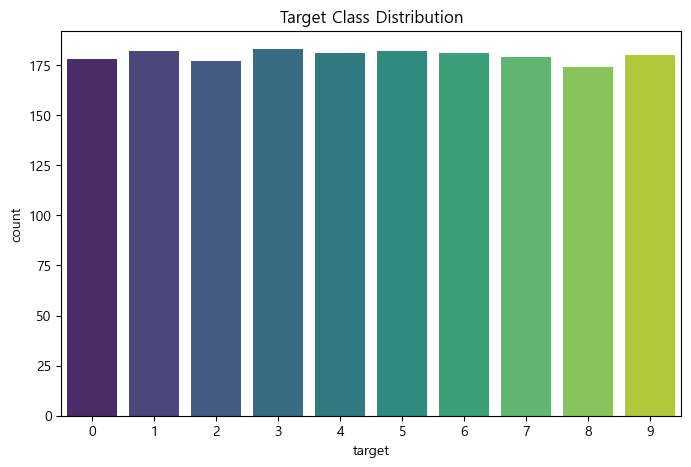

In [3]:
# 타겟 데이터 분포 확인
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Target Class Distribution')
plt.show()

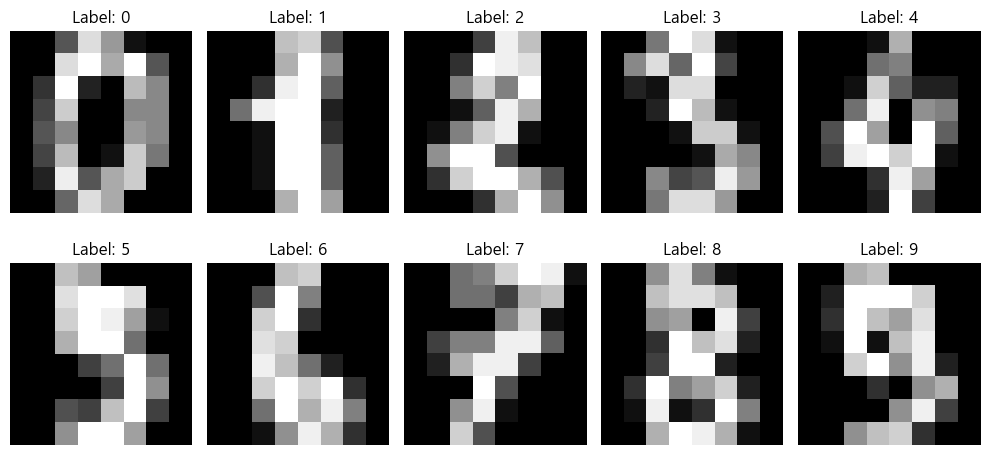

In [5]:
# 실제 이미지 시각화
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f'Label: {digits.target[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 2. 데이터 전처리 및 특성 공학 (Feature Engineering)

In [6]:
# 피처와 타겟 분리
X = digits.data
y = digits.target

# 학습/데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 데이터 스케일링 (픽셀 값의 범위를 표준화)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1437, 64)
X_test shape: (360, 64)


In [13]:
# y_train의 레이블별 데이터 갯수 세기
unique, counts = np.unique(y, return_counts=True)
print(counts)
unique, counts = np.unique(y_train, return_counts=True)
print(counts)
unique, counts = np.unique(y_test, return_counts=True)
print(counts)

[178 182 177 183 181 182 181 179 174 180]
[142 146 142 146 145 145 145 143 139 144]
[36 36 35 37 36 37 36 36 35 36]


## 3. 모델링 (6가지 모델)

In [17]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

model_results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    model_results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

# 성능 순서대로 정렬
sorted_results = sorted(model_results.items(), key=lambda x: x[1], reverse=True)
top_4_models = [name for name, acc in sorted_results[:4]]
print(f"\nTop 4 Models for Ensemble: {top_4_models}")

Logistic Regression Accuracy: 0.9722
Decision Tree Accuracy: 0.8194
Random Forest Accuracy: 0.9722
SVM Accuracy: 0.9750
KNN Accuracy: 0.9639
Gradient Boosting Accuracy: 0.9528

Top 4 Models for Ensemble: ['SVM', 'Logistic Regression', 'Random Forest', 'KNN']


## 4. 하이퍼파라미터 튜닝 및 앙상블 모델

In [10]:
# SVM 튜닝 예시
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}
grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=3, scoring='accuracy')
grid_svm.fit(X_train_scaled, y_train)
best_svm = grid_svm.best_estimator_

# Random Forest 튜닝 예시
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=3, scoring='accuracy')
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_

# KNN 튜닝 예시
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9]
}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='accuracy')
grid_knn.fit(X_train_scaled, y_train)
best_knn = grid_knn.best_estimator_

# Logistic Regression 튜닝 예시
param_grid_lr = {
    'C': [0.1, 1, 10]
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=3, scoring='accuracy')
grid_lr.fit(X_train_scaled, y_train)
best_lr = grid_lr.best_estimator_

In [11]:
# 앙상블 (Voting Classifier)
voting_clf = VotingClassifier(
    estimators=[
        ('SVM', best_svm),
        ('RF', best_rf),
        ('KNN', best_knn),
        ('LR', best_lr)
    ],
    voting='soft'
)

voting_clf.fit(X_train_scaled, y_train)
y_pred_ensemble = voting_clf.predict(X_test_scaled)
ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

print(f"Ensemble Model Accuracy: {ensemble_acc:.4f}")

Ensemble Model Accuracy: 0.9861


## 5. 모델 평가

### Classification Report (Ensemble Model) ###
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.95      0.97      0.96        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.97      0.97      0.97        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       0.97      1.00      0.99        36
           8       0.97      0.94      0.96        35
           9       1.00      1.00      1.00        36

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



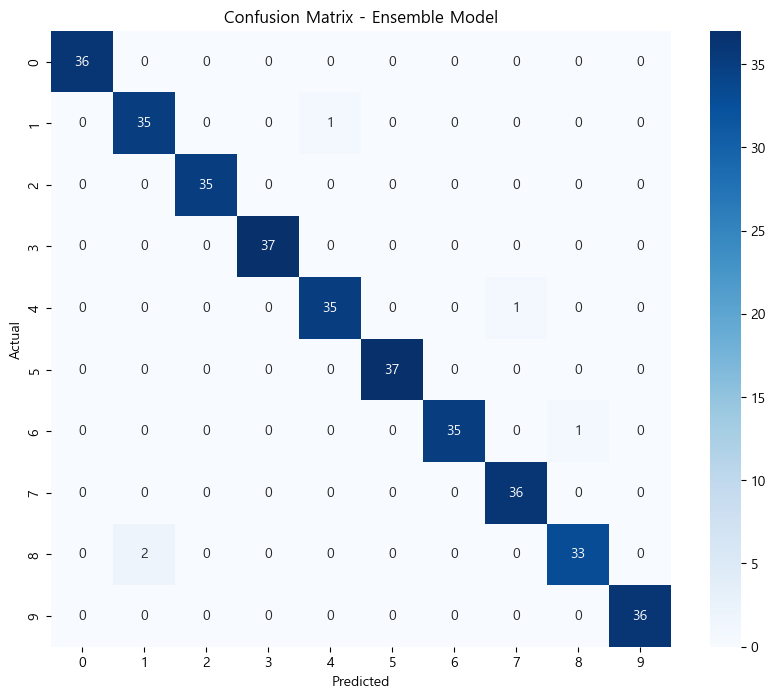

In [12]:
print("### Classification Report (Ensemble Model) ###")
print(classification_report(y_test, y_pred_ensemble))

# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()